In [59]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [60]:
# plt.rcParams['figure.figsize'] = (15,10)
# plt.rcParams['figure.dpi'] = 100

In [61]:
true_temp_df = pd.read_csv("csv_files/weather.csv", usecols=['temp', 'dt', 'today'], dtype={'dt': 'int64'})
forecast_temp_df = pd.read_csv("csv_files/forecast.csv", usecols=['temp', 'dt', 'today'], dtype={'dt': 'int64'})
join_data_df = pd.read_csv("csv_files/join.csv", usecols=['temp', 'dt', 'today', 't5', 't4', 't3', 't2', 't1'])
metrics_df = pd.read_csv("csv_files/metrics.csv")

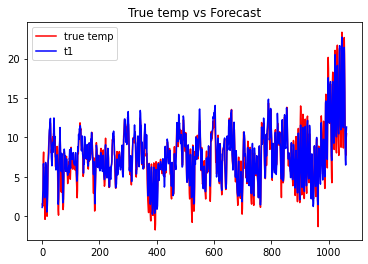

In [97]:
N = join_data_df.shape[0]
min_x = 0
max_x = N
x = np.linspace(0,max_x-min_x,max_x-min_x)
plt.plot(x, join_data_df['temp'][min_x:max_x], label='true temp', color='red')
plt.plot(x, join_data_df['t1'][min_x:max_x], label='t1', color='blue')
# plt.plot(x, join_data_df['t4'][min_x:max_x], label='t4', color='grey', marker='^')
# plt.plot(x, join_data_df['t3'][min_x:max_x], label='t3', color='purple', marker='|')
# plt.plot(x, join_data_df['t2'][min_x:max_x], label='t2', color='orange', marker='|')
# plt.plot(x, join_data_df['t1'][min_x:max_x], label='t1', color='green', marker='*')
plt.title("True temp vs Forecast")
plt.legend()
plt.show()

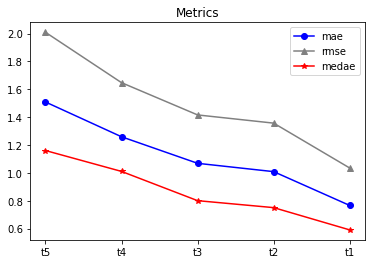

In [63]:
# plt.rcParams['figure.figsize'] = (7,3)
x = np.linspace(0,1,5)
axes= plt.axes()
axes.set_xticks(x)
axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
plt.plot(x, metrics_df['mae'], label='mae', color='blue', marker='o')
plt.plot(x, metrics_df['rmse'], label='rmse', color='grey', marker='^')
plt.plot(x, metrics_df['medae'], label='medae', color='red', marker='*')
plt.title("Metrics")
plt.legend()
plt.show()

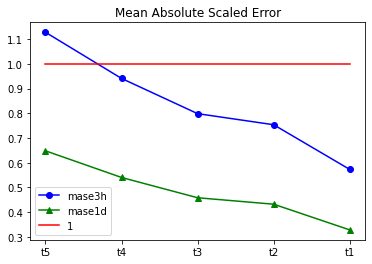

In [64]:
x = np.linspace(0,1,5)
axes= plt.axes()
axes.set_xticks(x)
axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
plt.plot(x, metrics_df['mase'], label='mase3h', color='blue', marker='o')
plt.plot(x, metrics_df['mase1d'], label='mase1d', color='green', marker='^')
plt.plot(x, np.ones(5), label='1', color='red')
plt.title("Mean Absolute Scaled Error")
plt.legend()
plt.show()

In [65]:
true_temp_df.describe()

,temp,dt
count,1421.000000,1.421000e+03
mean,8.544729,1.582578e+09
std,4.628126,4.431798e+06
min,-1.720000,1.574910e+09
25%,5.720000,1.578744e+09
50%,7.960000,1.582578e+09
75%,10.600000,1.586412e+09
max,26.910000,1.590246e+09


In [66]:
true_temp_df.head(5)

,temp,dt,today
0,8.19,1574910000,2019-11-28
1,8.19,1574920800,2019-11-28
2,7.93,1574931600,2019-11-28
3,9.36,1574942400,2019-11-28
4,9.32,1574953200,2019-11-28
